In [2]:
import tikzplotlib
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("RKI_COVID19.csv", parse_dates=["Meldedatum", "Refdatum"])

## Clean Data
Only consider entries where:
 * NeuerFall is not -1 "Anzahl Fälle der aktuellen Publikation als Summe(AnzahlFall), wenn NeuerFall in (0,1); Delta zum Vortag als Summe(AnzahlFall) wenn NeuerFall in (-1,1)" [RKI](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)
 * The delay is smaller than two weeks.
 * The case is not reported before the date of illness.
 * The flag "IstErkrankungsbeginn" is set.
 * Drop all columns, which are not necessary for extracting the delay pattern.

In [3]:
data_cleaned = data[data["NeuerFall"] != -1]
data_cleaned = data_cleaned[data_cleaned["Meldedatum"] < data_cleaned["Refdatum"] + pd.Timedelta(days=14)]
data_cleaned = data_cleaned[data_cleaned["Meldedatum"] >= data_cleaned["Refdatum"]]
data_cleaned = data_cleaned[data_cleaned["IstErkrankungsbeginn"] == 1]
data_dropped = data_cleaned.drop(["FID", "IdBundesland", "Bundesland", "Landkreis", "Altersgruppe","Geschlecht", "NeuerTodesfall", "AnzahlTodesfall", "NeuerFall", "NeuGenesen","IstErkrankungsbeginn", "AnzahlGenesen", "IdLandkreis", "Altersgruppe2"], axis=1)
data_dropped.head()

,AnzahlFall,Meldedatum,Datenstand,Refdatum
3,1,2020-09-25,"16.10.2020, 00:00 Uhr",2020-09-21
4,1,2020-09-26,"16.10.2020, 00:00 Uhr",2020-09-21
7,1,2020-09-24,"16.10.2020, 00:00 Uhr",2020-09-23
10,1,2020-03-19,"16.10.2020, 00:00 Uhr",2020-03-13
11,1,2020-03-19,"16.10.2020, 00:00 Uhr",2020-03-16


In [4]:
data_complete = data[data["NeuerFall"] != -1]

data_rest =  data_complete[data_complete["Meldedatum"] >= data_complete["Refdatum"] + pd.Timedelta(days=14)]
data_rest =  data_rest[data_rest["Meldedatum"] >= data_rest["Refdatum"]]
data_rest =  data_rest[data_rest["IstErkrankungsbeginn"] == 1]

data_used = data_complete[data_complete["Meldedatum"] < data_complete["Refdatum"] + pd.Timedelta(days=14)]
data_used = data_cleaned[data_cleaned["Meldedatum"] >= data_cleaned["Refdatum"]]
data_used = data_cleaned[data_cleaned["IstErkrankungsbeginn"] == 1]

len(data_used)/len(data_rest)

13.019076688286914

## Perform Calculation
1. Calculate for each date of illness ("Refdatum") and report date ("Meldedatum") the sum of reported new cases.
2. Calculate the difference between report date and date of illness
3. Calculate the share of each delay per weekday. I.e., group the dates by weekday and delay, calculate the sum of this grouping and divide it by the summed grouping by the weekday

In [5]:
grouped_data = data_dropped.groupby(["Refdatum", "Meldedatum"]).sum()

In [6]:
delayed = grouped_data.reset_index()
delayed["Verzögerung"] = (delayed["Meldedatum"] - delayed["Refdatum"]).dt.days

In [7]:
delayed["weekday"] = delayed["Refdatum"].dt.dayofweek
temp = (delayed.groupby(["weekday", "Verzögerung"]).sum() / delayed.groupby(["weekday"]).sum().drop(["Verzögerung"],axis=1))
temp.to_csv("true_delay_pattern.csv")
temp

AnzahlFall
weekday Verzögerung            
0       0              0.020137
        1              0.088160
        2              0.154359
        3              0.162823
        4              0.137684
...                         ...
6       9              0.052115
        10             0.046780
        11             0.033207
        12             0.021426
        13             0.012805

[98 rows x 1 columns]

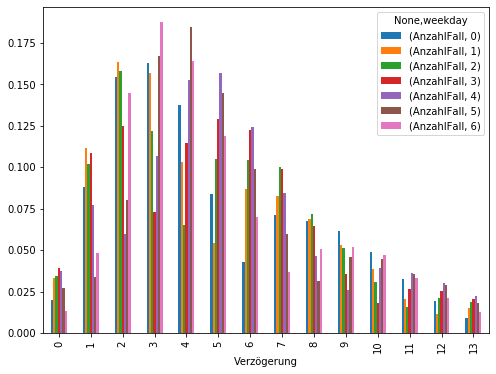

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
temp.reset_index().pivot("Verzögerung", "weekday").plot(kind="bar", ax=ax)
tikzplotlib.save("trueDelayPattern_grouped.tex")
plt.show()

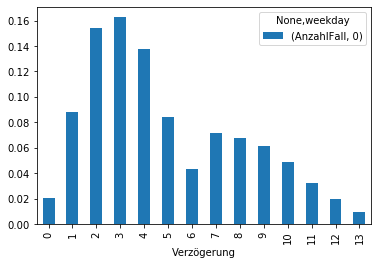

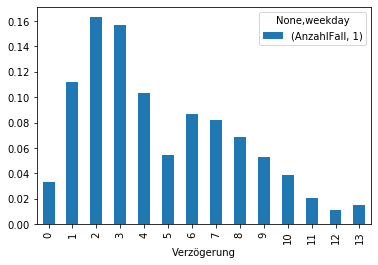

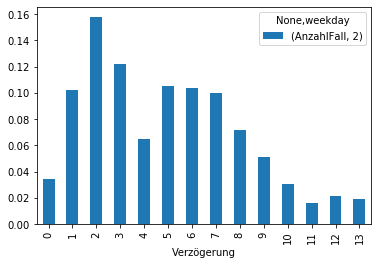

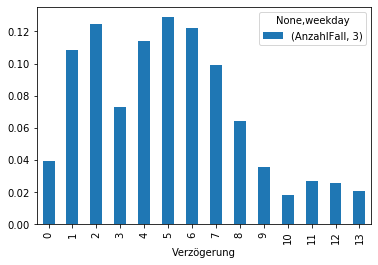

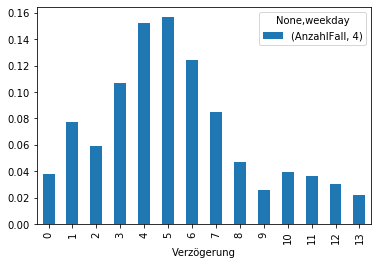

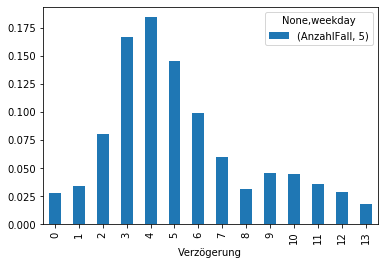

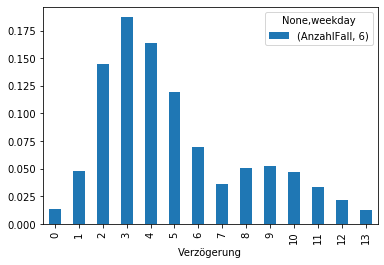

In [9]:
for i in range(7):
    temp.reset_index()[temp.reset_index()["weekday"] == i].pivot("Verzögerung", "weekday").plot(kind="bar")

In [10]:
data_cleaned = data[data["NeuerFall"] != -1]

data_used = data_cleaned[data_cleaned["Meldedatum"] >= data_cleaned["Refdatum"]]
data_used = data_used[data_cleaned["Meldedatum"] < data_cleaned["Refdatum"] + pd.Timedelta(days=14)]
data_used = data_used[data_cleaned["IstErkrankungsbeginn"] == 1]
d = data_used.groupby(["Meldedatum", "Refdatum"]).sum()
d = d.reset_index()

d["Verzögerung"] = (d["Meldedatum"] - d["Refdatum"]).dt.days
print(max(d["Verzögerung"]))
d = d.loc[:, ["AnzahlFall", "Verzögerung"]]
print(max(d["Verzögerung"]))

sum(d["AnzahlFall"].values * d["Verzögerung"].values)/ d["AnzahlFall"].values.sum()


13
13


C:\Users\bi4372\.conda\envs\timeseries\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\bi4372\.conda\envs\timeseries\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


4.989642086927671

## Compare if delay pattern changes
Therefore in a first step compare the delay patterns in the first half and in the second half of the dataset.

### Result
* The delay pattern differs from the first half to the second half.
* Moreover, we observe that the average delay decreases through time

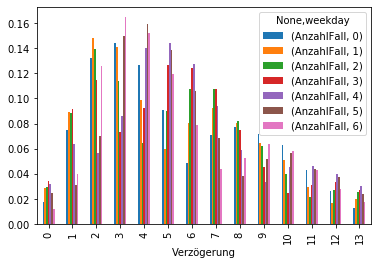

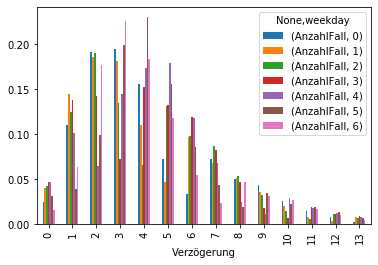

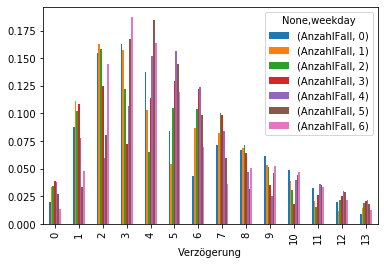

AnzahlFall
weekday Verzögerung            
0       0             -0.007739
        1             -0.035642
        2             -0.060263
        3             -0.051078
        4             -0.029511
...                         ...
6       9              0.032402
        10             0.031772
        11             0.026323
        12             0.017415
        13             0.012731

[98 rows x 1 columns]

In [11]:
first_half = delayed[ : len(delayed) // 2]
second_half = delayed[len(delayed) // 2:]
temp_first = (first_half.groupby(["weekday", "Verzögerung"]).sum() / first_half.groupby(["weekday"]).sum().drop(["Verzögerung"],axis=1))
temp_second = (second_half.groupby(["weekday", "Verzögerung"]).sum() / second_half.groupby(["weekday"]).sum().drop(["Verzögerung"],axis=1))

temp_first.reset_index().pivot("Verzögerung", "weekday").plot(kind="bar")
temp_second.reset_index().pivot("Verzögerung", "weekday").plot(kind="bar")
temp.reset_index().pivot("Verzögerung", "weekday").plot(kind="bar")
plt.show()

temp_first - temp_second


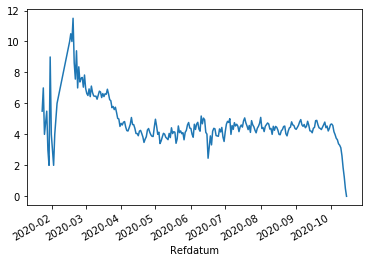

In [15]:
delayed = grouped_data.reset_index()
delayed["Verzögerung"] = (delayed["Meldedatum"] - delayed["Refdatum"]).dt.days
d = delayed
delayed["mult"] = delayed["Verzögerung"] * delayed["AnzahlFall"]
grouped_delay = delayed.groupby("Refdatum").sum()
(grouped_delay["mult"] / grouped_delay["AnzahlFall"]).plot()
